In [1]:
 !wget https://www.dropbox.com/s/0s5faym8vg505o0/BrainTumorData.zip?dl=0

--2021-12-19 23:18:15--  https://www.dropbox.com/s/0s5faym8vg505o0/BrainTumorData.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0s5faym8vg505o0/BrainTumorData.zip [following]
--2021-12-19 23:18:15--  https://www.dropbox.com/s/raw/0s5faym8vg505o0/BrainTumorData.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5bcd0e4b036fd4f267053e197e.dl.dropboxusercontent.com/cd/0/inline/BcLN71itXZO7x8LpvJ51914uqAsF60f3pwr4zaKRHOq27dbwe8jIUh89LD2VMzBrZ8yu3oUuU3HqnyI6kON5qSgHy-YBc2iNwwi5s70y8C_UxQM2wO6-wR5sZVH9csl_1WoIVN805aGBc-n5jjExRYfF/file# [following]
--2021-12-19 23:18:15--  https://uc5bcd0e4b036fd4f267053e197e.dl.dropboxusercontent.com/cd/0/inline/BcLN71itXZO7x8LpvJ51914uqAsF60f3pwr4zaKRHOq27dbwe8jIUh89LD2VMzBr

In [2]:
!unzip /content/BrainTumorData.zip?dl=0

Streaming output truncated to the last 5000 lines.
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (3423).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (3424).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (3425).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (3426).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (3427).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (3428).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (3429).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (343).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (3430).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (3431).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (3432).jpg  
  inflating: BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (34

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob 
import tensorflow as tf

In [5]:
#count the number of images in the respective classes 
root_dir = "/content/BrainTumorData/Brain Tumor Data Set"
no_of_images={}
for dir in os.listdir(root_dir):
  no_of_images[dir]=len(os.listdir(os.path.join(root_dir,dir)))
print(no_of_images.items())

dict_items([('Healthey', 2580), ('Brain Tumor', 5143)])


# Split the data
# 70% for Training 
# 15% for validation
# 15% for testing

In [6]:
#Create folder for train test and valid a

def create_folder(folder_name,percentage):
  if not os.path.exists("./"+folder_name+"/"):
    os.mkdir("./"+folder_name+"/")
    for dir in os.listdir(root_dir):
      os.makedirs("./"+folder_name+"/"+dir)
      for image in np.random.choice(a = os.listdir(os.path.join(root_dir,dir)),
                                    size= (math.floor(percentage/100*no_of_images[dir])-2)
                                    ,replace=False):
        source = os.path.join(root_dir,dir,image)
        dest = os.path.join("./"+folder_name,dir)
        shutil.copy(source,dest)
        os.remove(source)

  else:
    print("Folder is already exist")      
      
  

In [7]:
#creating folder for train
create_folder("train",70)
#creating folder for valid
create_folder("valid",15)
#creating folder for test
create_folder("test",15)

#Model Building

In [8]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras



#Preparing our data using data Generator

In [9]:
def PreprocessingData(path):
  image_data = ImageDataGenerator(zoom_range=0.2,shear_range=0.2, rescale=1/255, horizontal_flip=True)
  
  image = image_data.flow_from_directory(directory = path, target_size =(224,224) , batch_size= 32 , class_mode ='binary')
  
  return image


In [10]:
def PreprocessingData_for_validtest(path):
  image_data = ImageDataGenerator(rescale=1/255)
  
  image = image_data.flow_from_directory(directory = path, target_size =(224,224) , batch_size= 32 , class_mode ='binary')
  
  return image

In [11]:
path="/content/train"
train_data = PreprocessingData(path)

Found 5401 images belonging to 2 classes.


In [12]:
path="/content/valid"
valid_data = PreprocessingData_for_validtest(path)

Found 1154 images belonging to 2 classes.


In [13]:
path ="/content/test"
test_data =  PreprocessingData_for_validtest(path)

Found 1154 images belonging to 2 classes.


In [14]:
# Early Stopping and model checkpoints

from keras.callbacks import ModelCheckpoint,EarlyStopping


#Early Stopping 

es = EarlyStopping (monitor="val_accuracy", min_delta=0.01, patience = 12, verbose=1 ,mode='auto')

#model checkpoint

mc = ModelCheckpoint(monitor="val_accuracy",
                      filepath= "./bestModel.h5", 
                      verbose=1,save_best_only= True, mode = 'auto')


cd= [es,mc]

#Model Training

In [15]:
model= Sequential()

model.add(Conv2D(16,(3,3), activation='relu' , input_shape= (224,224,3),padding='same' ))

model.add(Conv2D(32 ,(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64 ,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128 ,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(256 ,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Dropout(rate=0.25))


model.add(Flatten())

model.add(Dense(units=64, activation='relu'))

model.add(Dropout(rate=0.25))

model.add(Dense(units=1 , activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [16]:

model.compile(optimizer='adam',loss= keras.losses.binary_crossentropy, metrics=['accuracy'])

In [17]:
hs = model.fit_generator(generator=train_data, 
                         steps_per_epoch=12,epochs=40 , 
                        verbose=1 , validation_data=valid_data, 
                        validation_steps=16, callbacks=cd)

Epoch 1/40
12/12 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.6406
Epoch 00001: val_accuracy improved from -inf to 0.67383, saving model to ./bestModel.h5
12/12 [==============================] - 22s 715ms/step - loss: 0.6733 - accuracy: 0.6406 - val_loss: 0.6596 - val_accuracy: 0.6738
Epoch 2/40
12/12 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.6615
Epoch 00002: val_accuracy did not improve from 0.67383
12/12 [==============================] - 8s 701ms/step - loss: 0.6566 - accuracy: 0.6615 - val_loss: 0.6431 - val_accuracy: 0.6543
Epoch 3/40
12/12 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.6849
Epoch 00003: val_accuracy did not improve from 0.67383
12/12 [==============================] - 8s 682ms/step - loss: 0.6237 - accuracy: 0.6849 - val_loss: 0.6258 - val_accuracy: 0.6738
Epoch 4/40
12/12 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.6719
Epoch 00004: val_accuracy improv

In [24]:
#model accuracy 
from keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
model = tf.keras.models.load_model("/content/bestModel.h5")
acc= model.evaluate_generator(test_data)[1]
print(f"Model accuracy is {acc*100}")

Model accuracy is 89.16811347007751


In [19]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthey': 1}

In [25]:
print(hs.history.keys())
h = hs.history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


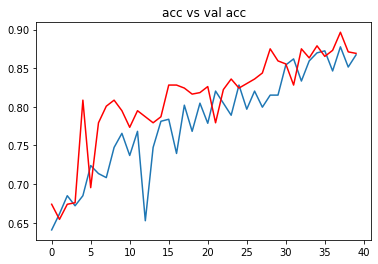

In [21]:
import matplotlib.pyplot as plt
plt.plot(h['accuracy']) 
plt.plot(h['val_accuracy'], c="red")
plt.title("acc vs val acc")
plt.show()


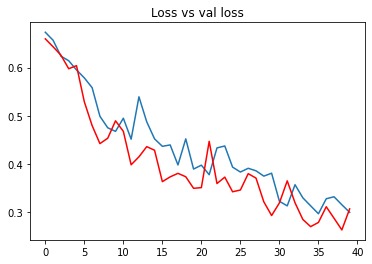

In [22]:
import matplotlib.pyplot as plt
plt.plot(h['loss']) 
plt.plot(h['val_loss'], c="red")
plt.title("Loss vs val loss")
plt.show()


Enter the Path of image:/content/BrainTumorData/Brain Tumor Data Set/Brain Tumor/Caner (145).jpg


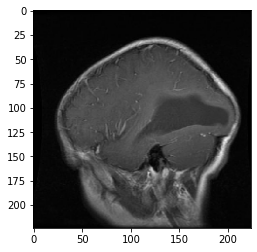

The image is having Brain Tumor


In [26]:
path= input("Enter the Path of image:")
image = load_img(path,target_size=(224,224))
image_arr = img_to_array(image)/255
plt.imshow(image_arr)
plt.show()
image_arr= np.expand_dims(image_arr, axis=0)

predictions = (model.predict(image_arr) > 0.6).astype("int32")[0][0]

if predictions==0:
  print("The image is having Brain Tumor")
else:
  print("The image is not having Brain Tumor")